# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    def __init__(self, narms):
        assert narms > 0, "number of arms should be greater than 0"
        self.narms = narms
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        return np.random.randint(low = 1, high = self.narms+1)
        
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of t a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.rewards[arm] += reward
        

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        assert epsilon >= 0, "Epsilon parameter should be between 0 and 1"
        assert epsilon <= 1, "Epsilon parameter should be between 0 and 1"
        super().__init__(narms)
        self.epsilon = epsilon
        self.Q0 = Q0
        self.counts = [0]*narms #list of counts of time played indexed by arm arm N(t)
        self.estimate = [Q0]*narms #list of estimates of each arm indexed by arm Q(t)
        
    def play(self, tround, context=None):
        
        #with probability epsilon random an arm
        if np.random.binomial(1, p=self.epsilon):
            return np.random.randint(self.narms)
        #with probability 1-epsilon take the argmax of the estimated value
        else:
            arr = np.array(self.estimate)
            #finding argmax and random tie breaking
            return np.argmax(np.random.random(arr.shape) * (arr==arr.max())) + 1
        
    def update(self, arm, reward, context=None):
        self.counts[arm-1] += 1
        #update estimates of the arm based on algo, if Q(t) = Q0 then calculate from starting.
        if self.estimate[arm-1] == self.Q0:
            self.estimate[arm-1] = 0 
        self.estimate[arm-1] += ((reward - self.estimate[arm-1]) / self.counts[arm-1] )
        
        
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        assert rho > 0, "rho hyperparameter should be greater than 0"
        super().__init__(narms)
        self.rho = rho
        self.Q0 = Q0
        self.counts = [0]*narms #list of counts of time played indexed by arm arm N(t)
        self.estimate = [Q0]*narms #list of estimates of each arm indexed by arm Q(t)
    
    def play(self, tround, context=None):
        
        UCB_est = list()
        #Calculate UpperBound if the arm has been pulled orelse the value is Q0
        for arm in range(self.narms):
            if self.counts[arm] == 0:
                UCB_est.append(self.Q0)  
            else:
                UCB_est.append(self.estimate[arm] +  np.sqrt(self.rho * np.log(tround) / self.counts[arm]))
            
        arr = np.array(UCB_est)
        #finding argmax and random tie breaking
        return np.argmax(np.random.random(arr.shape) * (arr==arr.max())) + 1
        
    def update(self, arm, reward, context=None):
        #update estimates of the arm based on algo, if Q(t) = Q0 then calculate from starting.
        self.counts[arm-1] += 1
        if self.estimate[arm-1] == self.Q0:
            self.estimate[arm-1] = 0
        self.estimate[arm-1] += ((reward - self.estimate[arm-1]) / self.counts[arm-1] )
        
        
        
    

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        assert alpha0 > 0, "alpha parameter should be greater than 0"
        assert beta0 > 0, "beta parameter should be greater than 0"
        super().__init__(narms)
        # initialize alpha and beta for each earm as a list indexed by arm
        self.alpha = [alpha0]*narms
        self.beta = [beta0]*narms
        
    def play(self, tround, context=None):
        # Sampling from Beta Distribution with alpha and beta for each arm
        sample = [np.random.beta(self.alpha[i]+1.0, self.beta[i]+1.0) for i in range(self.narms)]
        arr = np.array(sample)
        #finding argmax and random tie breaking
        return np.argmax(np.random.random(arr.shape) * (arr==arr.max())) + 1
        
        
    def update(self, arm, reward, context=None):
        # incrementing alpha if success (reward) and incrementing beta if failure (reward)
        if reward == 1.0:
            self.alpha[arm-1] += 1.0 
        else:
            self.beta[arm-1] += 1.0
        

## 3. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    hist = list()
    reward = list()
    count = 0
    
    # for each event (log file or dataset)
    for i in range(rewards.shape[0]):
        
        # Stop when found desired number of rounds of same arms pulled
        if count == nrounds:
            break   
        
        # pull an arm and check if it the same arm for that event.
        if mab.play(len(hist)+1,contexts[i,:]) == arms[i]:
            #if same arm pulled then update history and update MAB state
            mab.update(arms[i],rewards[i],contexts[i,:])
            hist.append((arms[i],rewards[i],contexts[i,:]))
            reward.append(rewards[i])
            count += 1
            
    return reward
    
    

In [7]:
# Load data set and split into arms, rewards and context
file = np.loadtxt("dataset.txt")
arms = file[:,0].astype(int)
rewards = file[:,1]
contexts = file[:,2:]

In [44]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.1375


In [49]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16625


In [50]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.22


## 4. Contextual Bandits - LinUCB

In [11]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        assert alpha >= 0.0, 'hyperparamter alpha must be a positive integer'
        assert ndims > 0, 'Number of dimension must be greater than 0'
        super().__init__(narms)
        self.alpha = alpha
        self.ndims = ndims
        self.A = [0] * narms
        self.c = [0] * narms
        # For each arm initialize the matrix A, context (c)
        for arm in range(narms):
            self.A[arm] = np.identity(self.ndims)
            self.c[arm] = np.zeros((self.ndims,1))
            
    def play(self, tround, context):
        # Split context to make it indexed my each arm
        context = context.reshape(-1,self.ndims) # reshape context to be indexed by each arm
        pt = [0] * self.narms
        std = [0] * self.narms
        theta = [0] * self.narms
        
        # For each arm calculate the UpperBound and add it to its expected payoff  
        for arm in range(self.narms):
            A_inv = inv(self.A[arm])
            xt = context[arm].reshape(-1, 1) #transpose vector of context for each arm to match dimensions.
            theta[arm] = np.dot(A_inv, self.c[arm])
            std[arm] = np.dot(self.alpha,np.sqrt(np.dot(xt.T, np.dot(A_inv, xt))))
            pt[arm] = theta[arm].T.dot(xt) + std[arm]
        
        # Return the arm with the highest value, and also tie breaking randomly
        arr = np.array(pt)
        return np.argmax(np.random.random(arr.shape) * (arr==arr.max())) + 1
        
    
    def update(self, arm, reward, context):
        # Update values of A and c
        context = context.reshape(-1,self.ndims)
        xt = context[arm-1].reshape(-1, 1)
        self.A[arm-1] += xt.dot(xt.T)
        self.c[arm-1] += reward * xt
    

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [13]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        assert v >= 0.0, "explore-exploit parameter must be positive value"
        assert ndims > 0, 'Number of dimension must be greater than 0'
        super().__init__(narms)
        self.v = v
        self.ndims = ndims
        self.B = np.identity(self.ndims)
        self.mu_hat = np.zeros((self.ndims,1))
        self.f = np.zeros((self.ndims,1))
        
        
    def play(self, tround, context):
        # Sample from mulitivariate normal distribution
        mu_tilda = np.random.multivariate_normal(self.mu_hat.flat, self.v**2 * inv(self.B))
        b = context.reshape(-1,self.ndims) #reshape context to be indexed by each arm
        # Calculate expected mu for each arm
        b_mu = np.dot(b,mu_tilda)
        arr = np.array(b_mu)
        
        # Return the arm with the highest value, and also tie breaking randomly 
        return np.argmax(np.random.random(arr.shape) * (arr==arr.max())) + 1
        
    
    def update(self, arm, reward, context):
        # Update the B matrix, f values and mu_hat values after each play for that arm
        context = context.reshape(-1,self.ndims)
        ba = context[arm-1].reshape(-1, 1)
        self.B += ba.dot(ba.T) 
        self.f += reward * ba
        self.mu_hat =inv(self.B).dot(self.f)
    

In [14]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.30125


## 6. Evaluation
### 6.A.

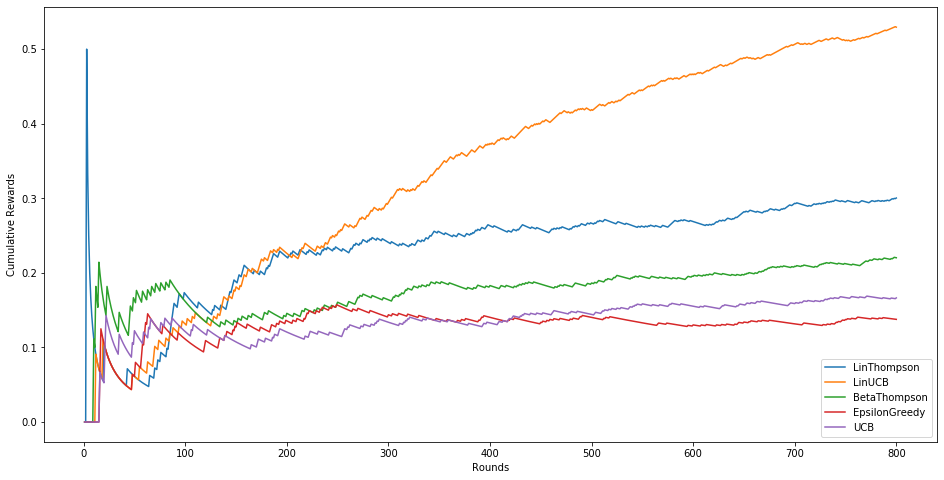

In [52]:
avg = {'LinT':[],
       'LinU':[],
       'BetaT':[],
       'EpsG':[],
       'UCB':[]}

for i in range(len(results_UCB)):
    if i != 0:
        avg['LinT'].append(np.mean(results_LinThompson[:i]))
        avg['LinU'].append(np.mean(results_LinUCB[:i]))
        avg['BetaT'].append(np.mean(results_BetaThompson[:i]))
        avg['EpsG'].append(np.mean(results_EpsGreedy[:i]))
        avg['UCB'].append(np.mean(results_UCB[:i]))
    else:
        avg['LinT'].append(results_LinThompson[0])
        avg['LinU'].append(results_LinUCB[0])
        avg['BetaT'].append(results_BetaThompson[0])
        avg['EpsG'].append(results_EpsGreedy[0])
        avg['UCB'].append(results_UCB[0])
    
plt.figure(figsize=(16,8))
plt.xlabel('Rounds')
plt.ylabel('Cumulative Rewards')
plt.plot(np.arange(1,len(results_UCB)+1), avg['LinT'],label = "LinThompson")
plt.plot(np.arange(1,len(results_UCB)+1), avg['LinU'],label = "LinUCB")
plt.plot(np.arange(1,len(results_UCB)+1), avg['BetaT'],label = "BetaThompson")
plt.plot(np.arange(1,len(results_UCB)+1), avg['EpsG'],label = "EpsilonGreedy")
plt.plot(np.arange(1,len(results_UCB)+1), avg['UCB'],label = "UCB")
plt.legend()
plt.show()

### 6.B.

# Grid Search for Alpha

    We will first test with a range of 0 - 10 with an increment of 0.5. 

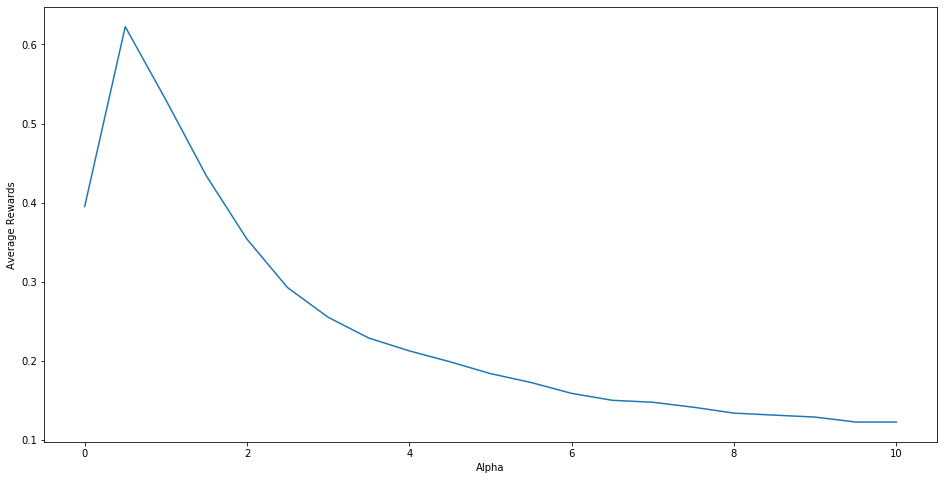

In [53]:
start = 0
stop = 10
step = .5
alphas = np.arange(start, stop+step, step)
results = list()

for alpha in alphas:
    mab = LinUCB(10, 10, alpha)
    results.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))

plt.figure(figsize=(16,8))
plt.xlabel('Alpha')
plt.ylabel('Average Rewards')
plt.plot(alphas,results)
plt.show()

    We can see that the lower values of alpha yield higher cumulative reward so we will do a refine search on the range of 0 - 1 with an increment of .01.

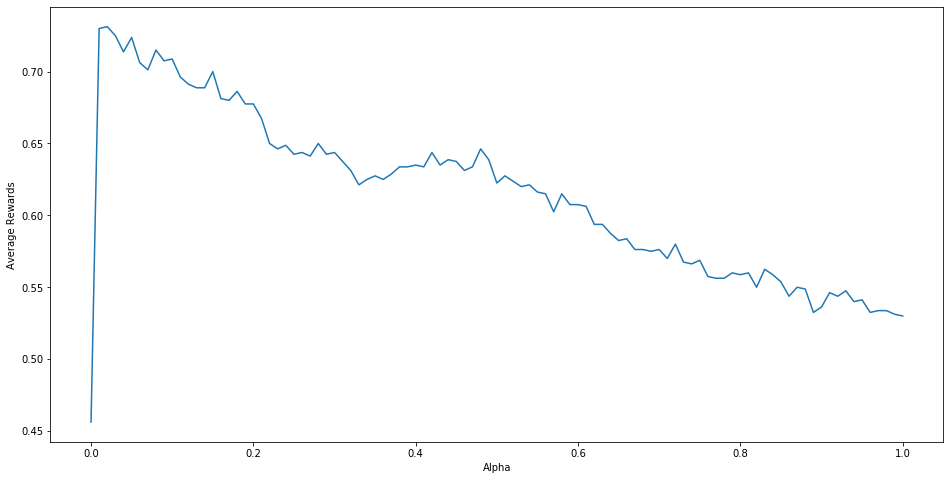

In [54]:
start = 0
stop = 1
step = .01
alphas = np.arange(start, stop+step, step)
results = list()

for alpha in alphas:
    mab = LinUCB(10, 10, alpha)
    results.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))

plt.figure(figsize=(16,8))
plt.xlabel('Alpha')
plt.ylabel('Average Rewards')
plt.plot(alphas,results)
plt.show()

In [55]:
print(f'Alpha value which yields the highest average rewards: {alphas[results.index(max(results))]}')

Alpha value which yields the highest average rewards: 0.02


# Grid Search for (V) parameter

    We will first test with a range of 0 - 10 with an increment of 0.5. 

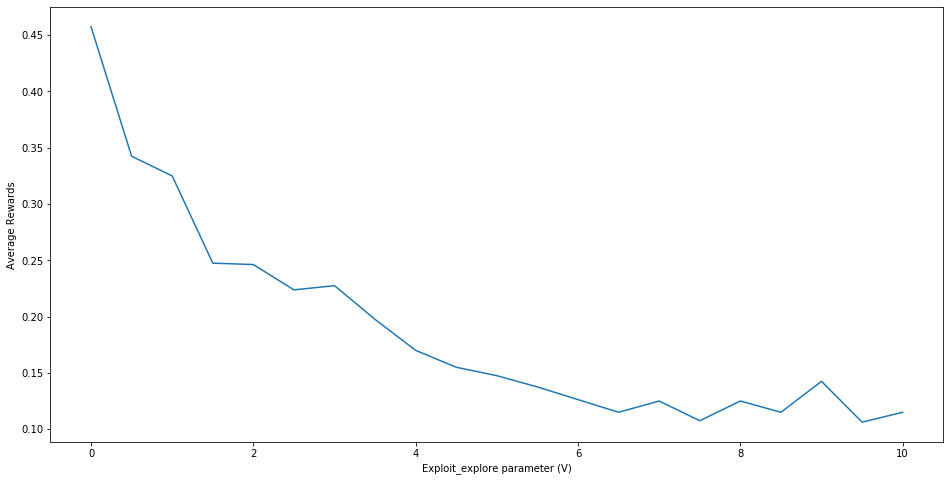

In [56]:
start = 0
stop = 10
step = .5
v_s = np.arange(start, stop+step, step)
results = list()

for v in v_s:
    mab = LinThompson(10, 10, v)
    results.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))

plt.figure(figsize=(16,8))
plt.xlabel('Exploit_explore parameter (V)')
plt.ylabel('Average Rewards')
plt.plot(v_s,results)
plt.show()

    We can observe the same pattern as alpha for this parameter as the lower values yied higher cumulative rewards so we will perform a refiner search. 

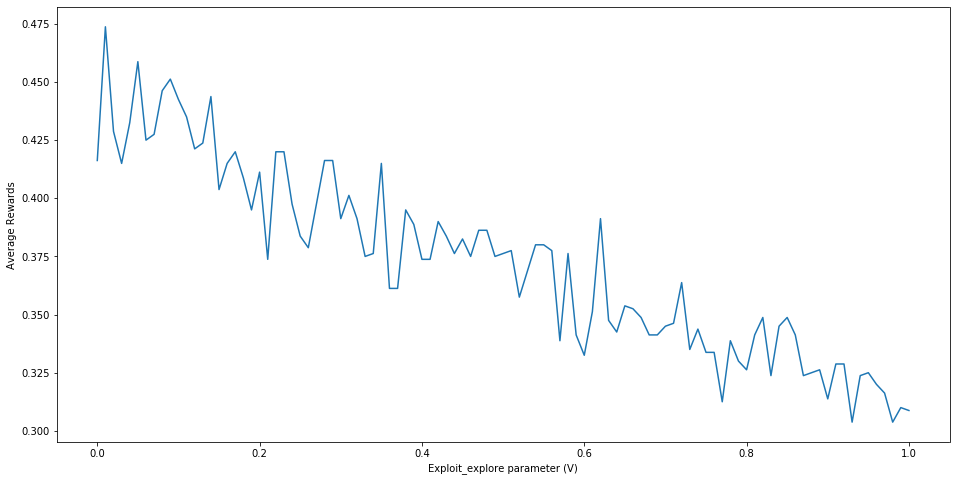

In [57]:
start = 0
stop = 1
step = .01
v_s = np.arange(start, stop+step, step)
results = list()

for v in v_s:
    mab = LinThompson(10, 10, v)
    results.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))

plt.figure(figsize=(16,8))
plt.xlabel('Exploit_explore parameter (V)')
plt.ylabel('Average Rewards')
plt.plot(v_s,results)
plt.show()

In [58]:
print(f'V parameter value which yields the highest average rewards: {v_s[results.index(max(results))]}')

V parameter value which yields the highest average rewards: 0.01
